In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import pickle

with open('/content/drive/MyDrive/egu23/covariates.pkl', 'rb') as f:
    covariates = pickle.load(f)

with open('/content/drive/MyDrive/egu23/target.pkl', 'rb') as f:
    target = pickle.load(f)

In [8]:
!pip install darts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached darts-0.24.0-py3-none-any.whl (693 kB)
  Using cached catboost-1.1.1-cp39-none-manylinux1_x86_64.whl (76.6 MB)
  Using cached pyod-1.0.9.tar.gz (149 kB)
  Preparing metadata (setup.py) ... done
  Using cached shap-0.41.0-cp39-cp39-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (572 kB)
  Using cached nfoursid-1.0.1-py3-none-any.whl (16 kB)
  Using cached pmdarima-2.0.3-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl (1.9 MB)
  Using cached pytorch_lightning-2.0.1.post0-py3-none-any.whl (718 kB)
  Using cached tensorboardX-2.6-py2.py3-none-any.whl (114 kB)
  Using cached tbats-1.1.2-py3-none-any.whl (43 kB)
  Using cached statsforecast-1.5.0-py3-none-any.whl (99 kB)
  Using cached torchmetrics-0.11.4-py3-none-any.whl (519 kB)
  Using cached lightning_utilities-0.8.0-py3-none-any.whl (20 kB)
  Using cached slicer-0.0.7-py3-none-any.whl (14 kB)
 

In [10]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys


import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)


from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TransformerModel
from darts.metrics import mape, rmse, r2_score
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression


pd.set_option("display.precision",2)
np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = '{:,.2f}'.format

In [25]:
len(covariates)

15

In [23]:
i = 0
target_list = []
covar_list = []

for i in range(0, len(covariates)):
  if len(covariates[i]) < 1000:
    i +=1
  
  else:
    target_list.append(TimeSeries.from_dataframe(target[i], time_col = 'TIMESTAMP', freq = '1D'))
    covar_list.append(TimeSeries.from_dataframe(covariates[i], time_col = 'TIMESTAMP', freq = '1D'))
    

In [24]:
len(covar_list)

14

In [26]:
EPOCHS = 50
INLEN = 365          # input size
FEAT =  8          # d_model = number of expected features in the inputs, up to 512    
HEADS = 4           # default 8
ENCODE = 4          # encoder layers
DECODE = 4          # decoder layers
DIM_FF = 128        # dimensions of the feedforward network, default 2048
BATCH = 128         #1095          # batch size
ACTF = "relu"       # activation function, relu (default) or gelu
SCHLEARN = None     # a PyTorch learning rate scheduler; None = constant rate
LEARN = 1e-3        # learning rate
VALWAIT = 1         # epochs to wait before evaluating the loss on the test/validation set
DROPOUT = 0.1       # dropout rate
N_FC = 1            # output size

RAND = 42           # random seed
N_SAMPLES = 100     # number of times a prediction is sampled from a probabilistic model
N_JOBS = -1          # parallel processors to use;  -1 = all processors



SPLIT = 0.8         # train/test %

FIGSIZE = (9, 6)

In [30]:
NEE_train_list = []
NEE_test_list = [] 

for i in range(0, len(covar_list)):
  NEE_train, NEE_test = target_list[i].split_after(SPLIT)

  NEE_train = NEE_train.astype('float64')
  NEE_test = NEE_test.astype('float64')

  NEE_train_list.append(NEE_train)
  NEE_test_list.append(NEE_test)


In [31]:
covar_train_list = []
covar_test_list = [] 

for i in range(0, len(covar_list)):
  covar_train, covar_test = covar_list[i].split_after(SPLIT)

  covar_train = covar_train.astype('float64')
  covar_test = covar_test.astype('float64')


  covar_train_list.append(covar_train)
  covar_test_list.append(covar_test)

In [32]:
# default quantiles for QuantileRegression
QUANTILES = [0.01, 0.1, 0.2, 0.5, 0.8, 0.9, 0.99]

In [33]:
model = TransformerModel(
                    input_chunk_length = INLEN,
                    output_chunk_length = N_FC,
                    batch_size = BATCH,
                    n_epochs = EPOCHS,
                    model_name = "Transformer_NEE",
                    nr_epochs_val_period = VALWAIT,
                    d_model = FEAT,
                    nhead = HEADS,
                    num_encoder_layers = ENCODE,
                    num_decoder_layers = DECODE,
                    dim_feedforward = DIM_FF,
                    dropout = DROPOUT,
                    activation = ACTF,
                    random_state=RAND,
                    likelihood=QuantileRegression(quantiles=QUANTILES), 
                    optimizer_kwargs={'lr': LEARN},
                    add_encoders={"cyclic": {"future": ["month"]}},
                    save_checkpoints=True,
                    force_reset=True
                    )

In [34]:
model.fit(NEE_train_list, past_covariates=covar_list, verbose=True)

Training: 0it [00:00, ?it/s]

TransformerModel(d_model=8, nhead=4, num_encoder_layers=4, num_decoder_layers=4, dim_feedforward=128, dropout=0.1, activation=relu, norm_type=None, custom_encoder=None, custom_decoder=None, input_chunk_length=365, output_chunk_length=1, batch_size=128, n_epochs=50, model_name=Transformer_NEE, nr_epochs_val_period=1, random_state=42, likelihood=<darts.utils.likelihood_models.QuantileRegression object at 0x7f9b11f72d90>, optimizer_kwargs={'lr': 0.001}, add_encoders={'cyclic': {'future': ['month']}}, save_checkpoints=True, force_reset=True)

In [ ]:
# testing: generate predictions
pred_list = []

for i in range(0, len(NEE_test_list)):
  NEE_pred = model.predict(n=len(NEE_test_list[i]),
                           series = NEE_train_list[i],
                           past_covariates=covar_list[i], 
                           num_samples=N_SAMPLES,   
                           n_jobs=N_JOBS, 
                           verbose=True)
  
  pred_list.append(NEE_pred)

import pickle

with open('./predictions.pkl', 'wb') as f:
  pickle.dump(pred_list, f)

with open('./actual.pkl', 'wb') as f:
  pickle.dump(NEE_test_list, f)

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [ ]:
for i in range(len(pred_list)):
  RMSE = rmse(NEE_test_list[i], pred_list[i])
  MAPE = mape(NEE_test_list[i], pred_list[i])
  R2 = r2_score(NEE_test_list[i], pred_list[i])
  
  print("RMSE:", f'{RMSE:.2f}')
  print("MAPE:", f'{MAPE:.2f}')
  print("R2:", f'{R2:.2f}')


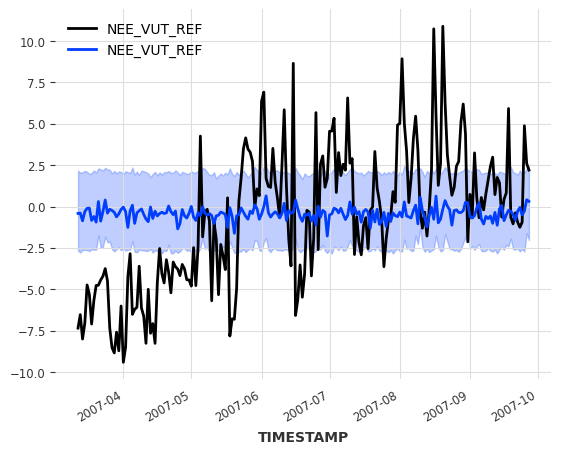

In [ ]:
NEE_test_list[1].plot()
pred_list[1].plot()